In [11]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os
from scipy.stats import norm

plt.rcParams['xtick.labelsize'] = 11
plt.rcParams['ytick.labelsize'] = 11
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.grid'] = True
plt.rcParams['legend.fontsize'] = 11
plt.rcParams['legend.loc'] = 'upper right'
plt.rcParams['axes.titlesize'] = 12

53.75
[103.75 211.25]
67.99698931313702 138.40383640831243
173.63798049532926 243.14243396059032



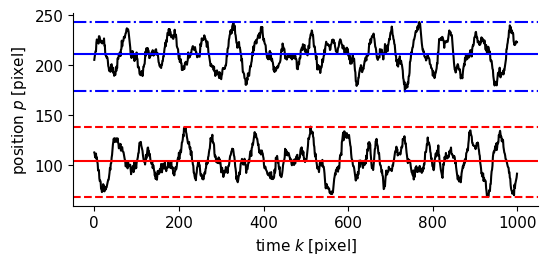

In [12]:
overlaps = ["00"]#, "06", "11", "17", "22", "28", "33", "39", "44", "50"]
overlap_values = [0, 0.06, 0.11, 0.17, 0.22, 0.28, 0.33, 0.39, 0.44, 0.5]
colors = ['r', 'b', 'k', 'g', 'm', 'c', 'y', 'orange', 'purple', 'pink']
linestyles = ['--', '-.', '--', '-.', '--', '-.']

for j, overlap in enumerate(overlaps):
    image_path =  (
        r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_2_traces\resampled\BE_UCC__HHE_2024-01-01T00-06-00_2024-01-14T00-12-00_1000_1_0-1\overlap_0-"
        + overlap
        + r"\signals\image_00005.jpg"
    )

    GT_path = (
        r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_2_traces\resampled\BE_UCC__HHE_2024-01-01T00-06-00_2024-01-14T00-12-00_1000_1_0-1\overlap_0-"
        + overlap
        + r"\ground_truth\sample_00005.npy"
    )   

    ground_truth = np.load(GT_path)
    max = ground_truth.max(axis=1)
    min = ground_truth.min(axis=1)

    image_source = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE).astype(np.float32)
    image_source = image_source.astype(np.float32) / 255.0  # Normalize to [0, 1]
    image_source = image_source.max() - image_source  # Invert the image
    # print("image shape", image_source.shape)
    height, width = image_source.shape
    t_margin, b_margin = 50, 50
    num_signals = 2

    plt.figure(figsize=(6, 2.5))
    # plt.imshow(image_source.max()-image_source, cmap='gray', origin='lower')
    plt.xlabel(r"time $k$ [pixel]")
    plt.ylabel(r"position $p$ [pixel]")
    
    available_height = height - t_margin - b_margin
    max_amplitude = (available_height / num_signals) / (1 - overlap_values[j])
    print(max_amplitude/2)
    vertical_offsets = np.linspace(t_margin + max_amplitude / 2, height - b_margin - max_amplitude / 2, num_signals)
    print(vertical_offsets)
    print(min[0], max[0])
    print(min[1], max[1])
    for i in range(len(max)):
        plt.plot(ground_truth[i], color='k')
        if i <2:
            plt.axhline(y=max[i], color=colors[i], linestyle=linestyles[i])
            plt.axhline(y=vertical_offsets[i], color=colors[i], linestyle='-')
            plt.axhline(y=min[i], color=colors[i], linestyle=linestyles[i])

    plt.grid(False)
    print()

    save_path = r"output_overlap\resampled\2_curves\overlap_{}.pdf".format(overlap)
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    plt.savefig(save_path, bbox_inches='tight', dpi=300, format='pdf')

# Proof the Gaussian noise hypothesis for Kalman Filtering Methods

[112.53377569 111.03964018 107.76474338 107.41426783 111.43496962
 106.13321222 107.66689711 103.44709232 101.25073228  94.41613679]
[111.03964018 107.76474338 107.41426783 111.43496962 106.13321222
 107.66689711 103.44709232 101.25073228  94.41613679  95.38370432]


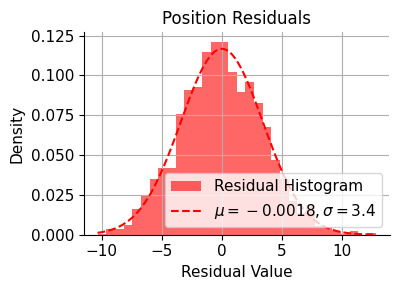

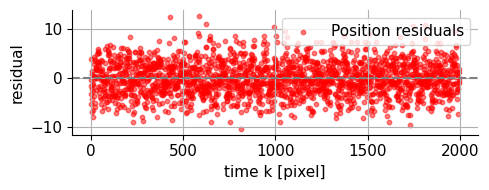

In [16]:
# Stack data from both curves
X = np.hstack([ground_truth[i, :-1] for i in range(len(ground_truth))])
Y = np.hstack([ground_truth[i, 1:] for i in range(len(ground_truth))])
print(X[:10])
print(Y[:10])

# Residuals assuming p_{k+1} = p_k + w_k
residuals = Y - X

# Fit a Gaussian to the residuals
mu, std = norm.fit(residuals)
x_vals = np.linspace(residuals.min(), residuals.max(), 100)

# Plot 2: Marginal Histograms with colors and axis labels
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
plt.hist(residuals, bins='auto', density=True, alpha=0.6, color='r', label='Residual Histogram')
    
mu, std = norm.fit(residuals)
x_vals = np.linspace(residuals.min(), residuals.max(), 100)
ax.plot(x_vals, norm.pdf(x_vals, mu, std), linestyle='--', color='r',
                label=f'$\\mu={mu:.2}, \\sigma={std:.2}$')
ax.set_title(f'Position Residuals')
ax.set_xlabel('Residual Value')
ax.set_ylabel('Density')
ax.legend(loc='lower right')
ax.grid(True)

plt.tight_layout()

plt.savefig(r"results\resampled_hist.pdf", bbox_inches='tight', dpi=300, format='pdf')

# Plot 3: Residuals over time (scatter)
plt.figure(figsize=(5, 2))
plt.scatter(np.arange(len(residuals)), residuals, s=10, alpha=0.5, label='Position residuals', color='r')
plt.axhline(0, color='gray', linestyle='--')
plt.xlabel('time k [pixel]')
plt.ylabel('residual')
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.savefig(r"results\resampled_residual.pdf", bbox_inches='tight', dpi=300, format='pdf')


In [14]:
# add a statistical test like Shapiro-Wilk to reinforce your conclusion:

from scipy.stats import shapiro

stat, p = shapiro(residuals)
print(f"Shapiro-Wilk test statistic = {stat:.4f}, p-value = {p:.4f}")
if p > 0.05:
    print("Residuals likely follow a Gaussian distribution (fail to reject H0).")
else:
    print("Residuals likely do NOT follow a Gaussian distribution (reject H0).")

Shapiro-Wilk test statistic = 0.9985, p-value = 0.0644
Residuals likely follow a Gaussian distribution (fail to reject H0).


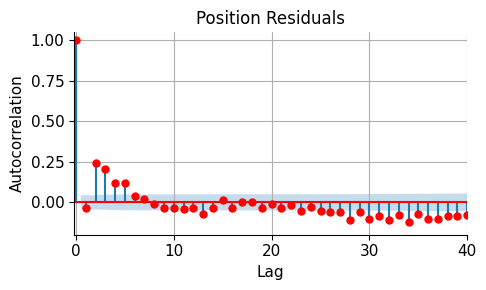

In [15]:
# verify whether the noise is uncorrelated (white):

from statsmodels.graphics.tsaplots import plot_acf

fig, ax = plt.subplots(1, 1, figsize=(5, 3))

# Position residuals
plot_acf(residuals, lags=40, ax=ax, color='r')
ax.set_title('Position Residuals')
ax.set_xlabel('Lag')
ax.set_ylabel('Autocorrelation')
ax.set_xlim(-0.2, 40)
ax.set_ylim(-0.2, 1.05)  # Adjust as needed based on your data

plt.tight_layout()

plt.savefig(r"results\resampled_autocorelation.pdf", bbox_inches='tight', dpi=300, format='pdf')